In [1]:
import pandas as pd
import numpy as np
from pylab import mpl, plt
import warnings
warnings.filterwarnings('ignore')

In [2]:
plt.style.use('seaborn')
mpl.rcParams['font.family'] = 'serif'
%matplotlib inline

## Data Preparation for Model Training

### Data Reading

In [3]:
start_date = '2016-01-01'
finish_date = '2021-03-01'

price = pd.read_csv("../data generators/generated_price_data/btc-usd_daily.csv")
price = price[['market','day','close']]
price.index = price['day']
price = price[(price['day'] >= start_date) & (price['day'] <= finish_date)]

g_trends = pd.read_csv("../data generators/generated_trends_data/bitcoin_daily.csv")
g_trends = g_trends[['keyword','day','trend']]
g_trends.index = g_trends['day']
g_trends = g_trends[(g_trends['day'] >= start_date) & (g_trends['day'] <= finish_date)]

g_trends2 = pd.read_csv("../data generators/generated_trends_data/coinbase_daily.csv")
g_trends2 = g_trends2[['keyword','day','trend']]
g_trends2.index = g_trends2['day']
g_trends2 = g_trends2[(g_trends2['day'] >= start_date) & (g_trends2['day'] <= finish_date)]

w_pageview = pd.read_csv("../data generators/generated_wiki_pageview_data/Bitcoin_daily.csv")
w_pageview = w_pageview[['article','day','pageview']]
w_pageview.index = w_pageview['day']
w_pageview = w_pageview[(w_pageview['day'] >= start_date) & (w_pageview['day'] <= finish_date)]

In [4]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import RandomizedSearchCV

### Feature Extraction
def create_features(data,key_val,window_len):
    features = np.zeros((1,window_len))
    for t in range(data.shape[0]-window_len):
        d = data[key_val].values[t:t+window_len].reshape(1,window_len)
        
        #Normalization to z-scores
        d = (d-d.mean())/np.std(d)
        features = np.concatenate((features,d))
    return features[1:,:]

preds = dict()
window_len_list = [14]
for window_len in window_len_list:
    print('window_len',window_len)
    price_features = create_features(price,'close',window_len)
    g_trends_features = create_features(g_trends,'trend',window_len)
    g_trends2_features = create_features(g_trends2,'trend',window_len)
    w_pageview_features = create_features(w_pageview,'pageview',window_len)

    features = np.hstack((price_features,g_trends_features,g_trends_features,w_pageview_features))
    features_small = price_features
    
    ### Assigning Class Labels

    returns = (price['close'] / price['close'].shift(1))-1
    returns = returns[window_len:]
    classes = np.array([ 1 if r >= 0 else -1 for r in returns ])
    classes = classes.reshape(classes.shape[0],1)
    classes.shape

    ### Model Training & Hyperparameter Tuning

    #features_dict = {'all':features,'price':features_small}
    features_dict = {'all':features}
    for features_k in features_dict.keys():
        print('features',features_k)
        features = features_dict[features_k]
        train_len = features.shape[0]-price[price['day'] >= '2019-12-31'].shape[0]
        x_train = features[:train_len,:]
        y_train = classes[:train_len,:]

        x_test = features[train_len:,:]
        y_test = classes[train_len:,:]

        random_grid = {'n_estimators': [25,50,100,200],
                       'learning_rate': [0.01,0.05,0.1,0.2],
                       'max_depth': [3,5,10,20],
                       #'min_samples_split': [5,10,20],
                       #'min_samples_leaf': [1,5,10] 
                      }

        gb = GradientBoostingClassifier()
        gb_random = RandomizedSearchCV(estimator = gb, 
                                       param_distributions = random_grid, 
                                       n_iter = 50, 
                                       cv = 4, 
                                       verbose=2, 
                                       random_state=42, 
                                       n_jobs = -1)
        #Fit the random search model
        gb_random.fit(x_train, y_train)

        model = GradientBoostingClassifier(n_estimators=gb_random.best_params_['n_estimators'],
                                           learning_rate=gb_random.best_params_['learning_rate'],
                                           max_depth=gb_random.best_params_['max_depth'])
        model.fit(x_train,y_train)

        print('\ttraining score:',model.score(x_train, y_train))
        print('\ttest score:',model.score(x_test,y_test))
        
        preds['gb_w'+str(window_len)+'_feature_'+features_k] = model.predict(x_test)[1:]

window_len 14
features all
Fitting 4 folds for each of 50 candidates, totalling 200 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    8.3s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:  2.4min finished


	training score: 0.5622406639004149
	test score: 0.5644028103044496


In [5]:
preds.keys()

dict_keys(['gb_w14_feature_all'])

## Momentum with Gradient Boosting

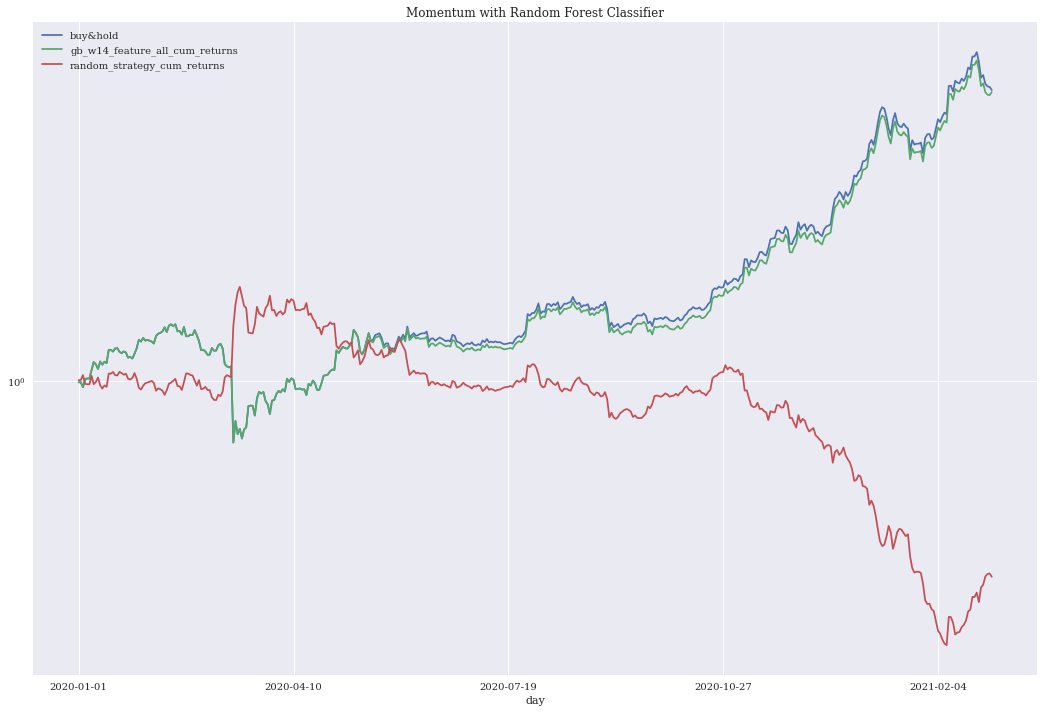

In [6]:
#take proportion of the data
test_data = price[(price['day'] >= '2019-12-31')]

#find buy&hold strategy returns
test_data['returns'] = (test_data['close'] / test_data['close'].shift(1))-1
test_data.dropna(inplace=True)
test_data['buy&hold'] = (1+test_data['returns'].values).cumprod()
returns_data = test_data[['returns','buy&hold']].copy()


#find returns
test_data = price[(price['day'] >= '2019-12-31')]
test_data['returns'] = (test_data['close'] / test_data['close'].shift(1))-1
test_data.dropna(inplace=True)
for kp in preds.keys():
    test_data[kp+'_returns'] = preds[kp] * test_data['returns']
test_data['random_strategy'] = np.where(np.random.rand(test_data.shape[0]) < 0.5, -1, 1)
test_data['random_strategy_returns'] = test_data['random_strategy'] * test_data['returns']

#find cumulative returns
test_data = test_data[test_data['day'] >= '2020-01-01']
for kp in preds.keys():
    returns_data[kp+'_returns'] = test_data[kp+'_returns'].values
    returns_data[kp+'_cum_returns'] = (1+returns_data[kp+'_returns'].values).cumprod()
returns_data['random_strategy_cum_returns'] = (1+test_data['random_strategy_returns'].values).cumprod()
    
plot_title = "Momentum with Random Forest Classifier"
plot_columns1 = ['buy&hold']+[kp+'_cum_returns' for kp in preds.keys()]+['random_strategy_cum_returns']
ax = returns_data[plot_columns1].plot(title=plot_title,figsize=(18, 12))
ax.set_yscale('log')
ax.get_legend()

### Visualizing Positions

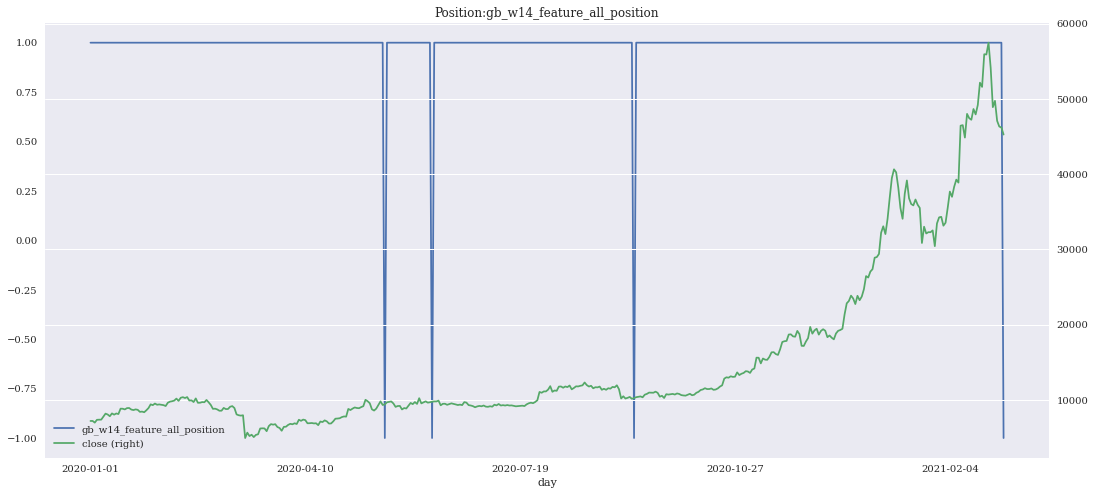

In [7]:
for kp in preds.keys():
    test_data[kp+'_position'] = preds[kp]
    ax = test_data[[kp+'_position','close']].plot(title='Position:'+kp+'_position',secondary_y='close',figsize=(18, 8))

### Feature Importance

In [8]:
importances = model.feature_importances_

indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(x_train.shape[1]):
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

Feature ranking:
1. feature 45 (0.119330)
2. feature 1 (0.108643)
3. feature 11 (0.079880)
4. feature 12 (0.070670)
5. feature 8 (0.056348)
6. feature 24 (0.055788)
7. feature 38 (0.054280)
8. feature 36 (0.053443)
9. feature 34 (0.052946)
10. feature 10 (0.043584)
11. feature 48 (0.042327)
12. feature 7 (0.034253)
13. feature 37 (0.032367)
14. feature 42 (0.029427)
15. feature 23 (0.021795)
16. feature 22 (0.020292)
17. feature 20 (0.019299)
18. feature 29 (0.019170)
19. feature 15 (0.018662)
20. feature 13 (0.012705)
21. feature 35 (0.010219)
22. feature 55 (0.009390)
23. feature 21 (0.007034)
24. feature 51 (0.006465)
25. feature 50 (0.006330)
26. feature 17 (0.006123)
27. feature 14 (0.005806)
28. feature 3 (0.003421)
29. feature 2 (0.000001)
30. feature 4 (0.000000)
31. feature 5 (0.000000)
32. feature 19 (0.000000)
33. feature 6 (0.000000)
34. feature 16 (0.000000)
35. feature 18 (0.000000)
36. feature 9 (0.000000)
37. feature 27 (0.000000)
38. feature 25 (0.000000)
39. feature 4